# **Grupo**


*   **Guilherme Carvalho**
*   **Breno Quessie**




# Coletando dados Tesouro

## **Problema:** Temos as cotações de títulos públicos no site da anbima, porém não temos as cotações diárias, veja o exemplo de tabela abaixo, nele são mostrados alguns vértices.


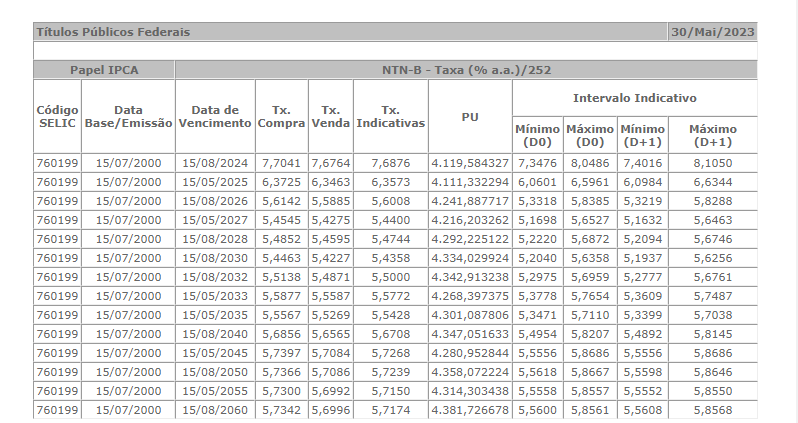

# **Solução Implementada nesse notebook**

Neste notebook iremos usar tecnicas de webscraping, faremos uma requisição get para coletar o html da pagina onde se encontra a tabela com as cotações e faremos algumas limpezas dos dados para se obter apenas o necessário.

Em um segundo momento faremos uso de uma tecnica de interpolação para conseguirmos achar as taxas para cada dia útil até a data que quisermos, no nosso caso faremos até 2050.

In [2]:
!pip install bizdays
!pip install workadays
import os
import requests
import bs4
from bs4 import BeautifulSoup
import sys
import pandas as pd
import time
import random
from sklearn.utils.extmath import cartesian
import IPython
from datetime import datetime
import re
import numpy as np
import requests
from datetime import datetime
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from workadays import workdays as wd
import bizdays
from datetime import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from datetime import datetime
from pandas.tseries.offsets import BDay
data_atual = datetime.today().date()
data_anterior = data_atual - BDay(1) 
print(data_anterior)

2023-05-30 00:00:00


In [4]:
#colocando a data de referencia que será usada para puxar as cotações dos títulos publicos.
# OBS: É importante lembrar que a Anbima so disponibiliza as cotações de até 5 dias para trás da data virgente.

# Obter a data de hoje
data_atual = datetime.today().date()
data_anterior = data_atual - BDay(1) 

data_formatada = data_anterior.strftime("%d/%m/%Y")

data_ref = data_formatada
data_ref_plan = data_anterior

meses = {
    1: "jan",
    2: "fev",
    3: "mar",
    4: "abr",
    5: "mai",
    6: "jun",
    7: "jul",
    8: "ago",
    9: "set",
    10: "out",
    11: "nov",
    12: "dez",
}

# Converte a string em um objeto datetime
data_obj = datetime.strptime(data_ref, "%d/%m/%Y")

# Formata a data no formato desejado (09mai2023)
dia_formatado = data_obj.strftime("%d")
mes_abreviado = meses[data_obj.month]
data_formatada = f"{dia_formatado.zfill(2)}{mes_abreviado}{data_obj.year}"

# url para coleta dos dados de NTN-B
url =f"https://www.anbima.com.br/informacoes/merc-sec/resultados/msec_{data_formatada}_ntn-b.asp"

html = requests.get(url).text


In [5]:
# tabela = soup.find('table')
# Usando beautifulsoup para limpar os dados recebidos do get da pagina. 
soup = BeautifulSoup(html, 'html.parser')
# filtrando todas as palavras em negrito
titulos = soup.find_all('b')

lista_titulos = []

i = 0

# appendando apenas os titulos.
for titulo in titulos:
    
    texto_titulo = titulo.get_text()
    if i >= 5 and i != 12 and i <= 16:
        lista_titulos.append(texto_titulo)
    i += 1

In [6]:
# Usando regex para filtrar apenas os dados da tabela

padrao = r'<TD\s+ALIGN\s*=\s*\'Center\'\s+VALIGN\s*=\s*\'Bottom\'>(.*?)</TD>'
resultados = re.findall(padrao, html, re.IGNORECASE)

In [7]:
array = np.array(resultados)

# Reshape para separar em linhas com 11 colunas
nova_matriz = array.reshape(-1, 11)
df = pd.DataFrame(nova_matriz)
df.columns = lista_titulos
df.insert(0, 'DataRef', data_ref_plan)
df['DataRef'] = pd.to_datetime(df['DataRef'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
df['Data de Vencimento'] = pd.to_datetime(df['Data de Vencimento'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

df

,DataRef,Código SELIC,Data Base/Emissão,Data de Vencimento,Tx. Compra,Tx. Venda,Tx. Indicativas,PU,Mínimo (D0),Máximo (D0),Mínimo (D+1),Máximo (D+1)
0,2023-05-30,760199,15/07/2000,2024-08-15,"7,7041","7,6764","7,6876","4.119,584327","7,3476","8,0486","7,4016","8,1050"
1,2023-05-30,760199,15/07/2000,2025-05-15,"6,3725","6,3463","6,3573","4.111,332294","6,0601","6,5961","6,0984","6,6344"
2,2023-05-30,760199,15/07/2000,2026-08-15,"5,6142","5,5885","5,6008","4.241,887717","5,3318","5,8385","5,3219","5,8288"
3,2023-05-30,760199,15/07/2000,2027-05-15,"5,4545","5,4275","5,4400","4.216,203262","5,1698","5,6527","5,1632","5,6463"
4,2023-05-30,760199,15/07/2000,2028-08-15,"5,4852","5,4595","5,4744","4.292,225122","5,2220","5,6872","5,2094","5,6746"
5,2023-05-30,760199,15/07/2000,2030-08-15,"5,4463","5,4227","5,4358","4.334,029924","5,2040","5,6358","5,1937","5,6256"
6,2023-05-30,760199,15/07/2000,2032-08-15,"5,5138","5,4871","5,5000","4.342,913238","5,2975","5,6959","5,2777","5,6761"
7,2023-05-30,760199,15/07/2000,2033-05-15,"5,5877","5,5587","5,5772","4.268,397375","5,3778","5,7654","5,3609","5,7487"
8,2023-05-30,760199,15/07/2000,2035-05-15,"5,5567","5,5269","5,5428","4.301,087806","5,3471","5,7110","5,3399","5,7038"
9,2023-05-30,760199,15/07/2000,2040-08-15,"5,6856","5,6565","5,6708","4.347,051633","5,4954","5,8207","5,4892","5,8145"


In [8]:
# Criando Colunas de Maturity (Vencimento) e DU (Dias Uteis ate o vencimento).
MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA')
df['Maturity'] = df['Data de Vencimento'].map(MARKET_CALENDAR.following)
df['DU'] = df.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
df


colunas_desejadas = ['DataRef', 'Data de Vencimento',"DU","Tx. Indicativas"]
df_taxas = df[colunas_desejadas]
df_taxas['Tx. Indicativas'] = pd.to_numeric(df_taxas['Tx. Indicativas'].str.replace(',', '.'))

df_taxas['Tx. Indicativas'] = pd.to_numeric(df_taxas['Tx. Indicativas'])
df_taxas

<ipython-input-8-0d55dbf62244>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxas['Tx. Indicativas'] = pd.to_numeric(df_taxas['Tx. Indicativas'].str.replace(',', '.'))
<ipython-input-8-0d55dbf62244>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxas['Tx. Indicativas'] = pd.to_numeric(df_taxas['Tx. Indicativas'])


,DataRef,Data de Vencimento,DU,Tx. Indicativas
0,2023-05-30,2024-08-15,305,7.6876
1,2023-05-30,2025-05-15,492,6.3573
2,2023-05-30,2026-08-15,810,5.6008
3,2023-05-30,2027-05-15,996,5.4400
4,2023-05-30,2028-08-15,1311,5.4744
5,2023-05-30,2030-08-15,1811,5.4358
6,2023-05-30,2032-08-15,2317,5.5000
7,2023-05-30,2033-05-15,2504,5.5772
8,2023-05-30,2035-05-15,3004,5.5428
9,2023-05-30,2040-08-15,4326,5.6708


In [9]:

refdate = datetime(2023, 5, 29)
cal = bizdays.Calendar.load('ANBIMA')

# **Achando os vertices mais próximos**

Vamos criar uma função para achar os vértices mais proximos da data de vencimento que queremos a taxa.

Essa função recebe um dataframe e uma data de vencimento, e vai achar a data mais próxima anterior a ela e a mais próxima posterior. Essas datas serão usadas mais na frente para o calculo das taxas interpoladas.

In [10]:
def find_closest_points(df,data):
    p1 = ()
    p2 = ()
    DU_x = cal.bizdays(refdate, data)
    menor_DU_maisProx = 0
    maior_DU_maisProx = float('inf')
    for i in range(len(df_taxas)):
        if (df_taxas.loc[i,"DU"] > menor_DU_maisProx and df_taxas.loc[i,"DU"] <= DU_x):
            menor_DU_maisProx = df_taxas.loc[i,"DU"]
            p1 = (df_taxas.loc[i,"DU"],df_taxas.loc[i,"Tx. Indicativas"])
        if (df_taxas.loc[i,"DU"] >= DU_x and df_taxas.loc[i,"DU"] < maior_DU_maisProx):
            maior_DU_maisProx = df_taxas.loc[i,"DU"]
            p2 = (df_taxas.loc[i,"DU"],df_taxas.loc[i,"Tx. Indicativas"])
    return p1,p2

# **Tecnica usada (Interpolcação de Taxas)**

A tecnica usada para achar as taxas foi uma interpolação de preços exponencial, como pode ser vista visitando o documento "Manual de Curvas da B3" 

link para o manual de curvas: https://www.b3.com.br/data/files/71/64/FB/58/A2A8F6109A4874F6AC094EA8/Manual_de_Curvas.pdf

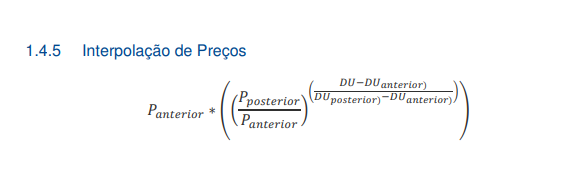

In [11]:
def calcula_fwd_rate(df,data):
    DU = cal.bizdays(refdate, data)
    DU_anterior = find_closest_points(df,data)[0][0]
    i_anterior = find_closest_points(df,data)[0][1]
    DU_posterior = find_closest_points(df,data)[1][0]
    i_posterior = find_closest_points(df,data)[1][1]
    I_a = (1 + i_anterior)**(DU_anterior/252)
    I_p = (1 + i_posterior)**(DU_posterior/252)
    resul = ((I_a * (I_p/I_a)**((DU - DU_anterior)/(DU_posterior - DU_anterior)))**(252/DU) - 1)
    return resul

In [16]:
from datetime import datetime, timedelta

# Definir a data inicial e a data final
data_inicial = datetime(2024, 8, 15)
data_final = datetime(2050, 12, 31)

# Calcular o intervalo de dias
dias = (data_final - data_inicial).days + 1

# Criar a lista de datas diárias
lista_datas = [data_inicial + timedelta(days=i) for i in range(dias)]

In [14]:
lista_taxas_interpoladas = []
for data in lista_datas:
  lista_taxas_interpoladas.append(calcula_fwd_rate(df_taxas,data))
  

<ipython-input-11-dfa98446e529>:9: RuntimeWarning: invalid value encountered in long_scalars
  resul = ((I_a * (I_p/I_a)**((DU - DU_anterior)/(DU_posterior - DU_anterior)))**(252/DU) - 1)


# Resultado

Por fim vamos plotar um grafico com as cotações diárias dos títulos públicos até 2050. 

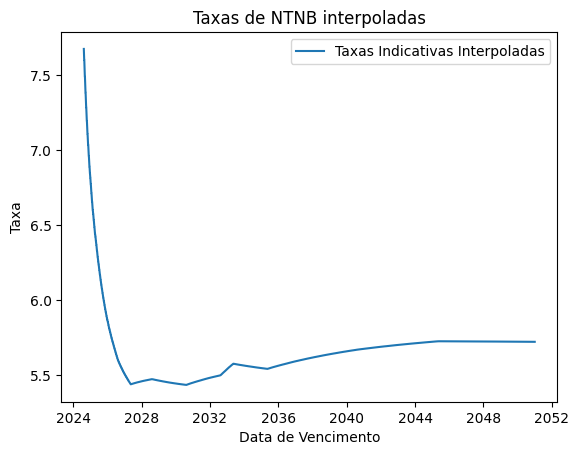

In [15]:
import matplotlib.pyplot as plt
plt.plot(lista_datas,lista_taxas_interpoladas , label='Taxas Indicativas Interpoladas')

# Definir legendas e título
plt.xlabel('Data de Vencimento')
plt.ylabel('Taxa')
plt.title('Taxas de NTNB interpoladas')

# Mostrar a legenda
plt.legend()

# Exibir o gráfico
plt.show()

# Comentários

Com esse resultado, podemos posteriormente fazer a mesma coisa para dados de di1 e com isso poderiamos descobrir a inflação implícita, uma vez descoberta essa inflção poderiamos usar para precificar ativos de renda fixa atrelados a inflação (IPCA+ por exemplo). Por isso é importante termos as cotações diárias.